In [381]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

In [382]:
%matplotlib inline

In [383]:
# Set default Seaborn style
sns.set()

In [384]:
file_path = '../datasets/dynamodb_20180823.json'

In [385]:
df = pd.read_json(file_path)

In [386]:
df.head()

,data,inquired,log,number,status
0,{'summary': {'date_balance': '17-07-2018 09:14...,1533957279,"{'active_contract': True, 'rut_required': False}",23569556,OK
1,{'summary': {'date_balance': '30-07-2018 09:10...,1533266814,"{'active_contract': True, 'rut_required': False}",22024384,OK
2,{'summary': {'date_balance': '01-08-2018 18:10...,1534199113,"{'active_contract': True, 'rut_required': False}",22559391,OK
3,{'summary': {'date_balance': '08-11-2016 14:49...,1533932867,"{'active_contract': True, 'rut_required': False}",20271880,without_trips
4,{'summary': {'date_balance': '26-07-2018 17:47...,1532783871,"{'active_contract': True, 'rut_required': False}",23899110,OK


### ¿Cómo se distribuyen los números de tarjetas respecto al estado de descarga de cada una?

In [206]:
print("len(dataset)=%d" % len(df))

len(dataset)=102959


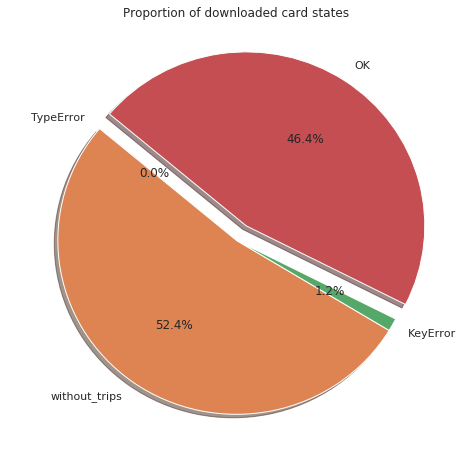

In [202]:
# Reorder randomly so that KeyError and TypeError are not together
chart_data = df['status'].value_counts().sample(frac=1)
sizes = chart_data.values
labels = chart_data.index
explode = [0.1 if _ == 'OK' else 0 for _ in labels]
_ = plt.figure(figsize=(8, 8))
_ = plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', shadow=True, startangle=140)
_ = plt.title('Proportion of downloaded card states')

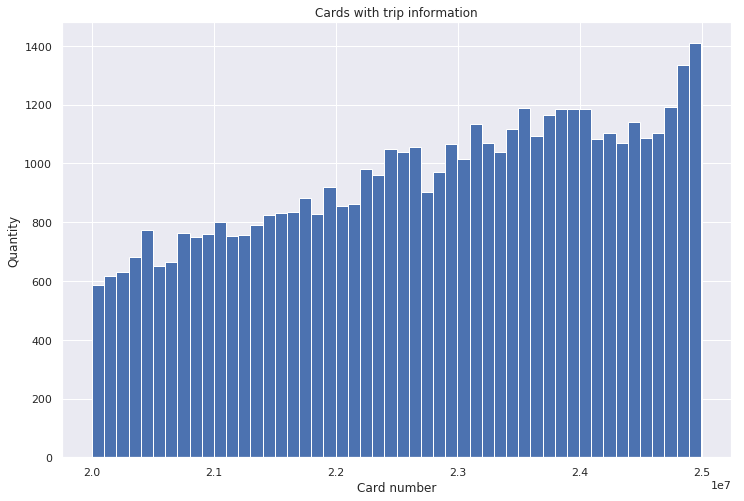

In [179]:
_ = plt.figure(figsize=(12, 8))
_ = plt.hist(df[df['status'] == 'OK']['number'], bins=50)
_ = plt.xlabel('Card number')
_ = plt.ylabel('Quantity')
_ = plt.title('Cards with trip information')

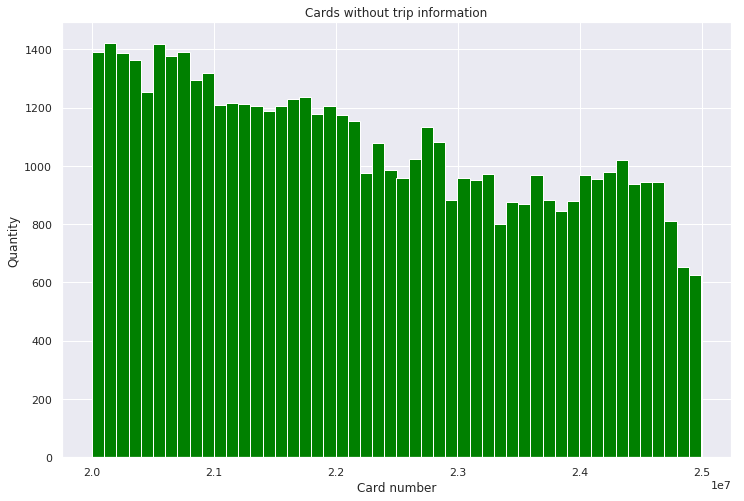

In [20]:
_ = plt.figure(figsize=(12, 8))
_ = plt.hist(df[df['status'] == 'without_trips']['number'], bins=50, color='green')
_ = plt.xlabel('Card number')
_ = plt.ylabel('Quantity')
_ = plt.title('Cards without trip information')

In [203]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    
    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, len(x) + 1) / n

    return x, y

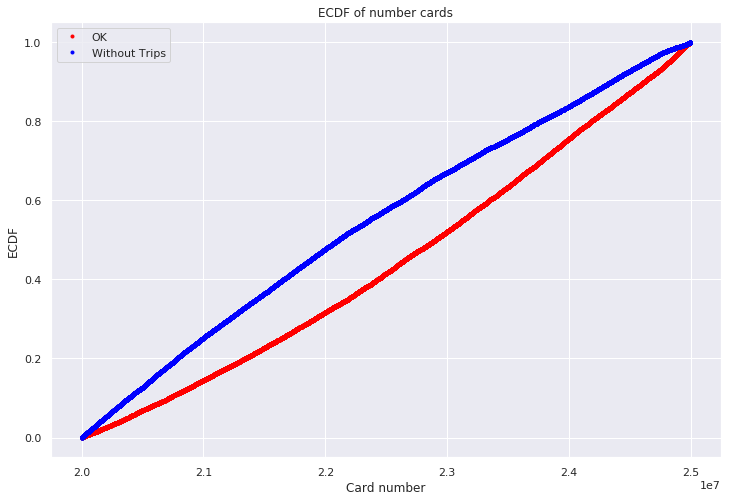

In [36]:
x_ok, y_ok = ecdf(df[df['status'] == 'OK']['number'])
x_wt, y_wt = ecdf((df[df['status'] == 'without_trips']['number']))

# Generate plot
_ = plt.figure(figsize=(12, 8))
_ = plt.plot(x_ok, y_ok, marker='.', linestyle='none', color='red')
_ = plt.plot(x_wt, y_wt, marker='.', linestyle='none', color='blue')

# Label the axes
_ = plt.xlabel('Card number')
_ = plt.ylabel('ECDF')
_ = plt.title('ECDF of number cards')
_ = plt.legend(['OK', 'Without Trips'], loc='upper left')


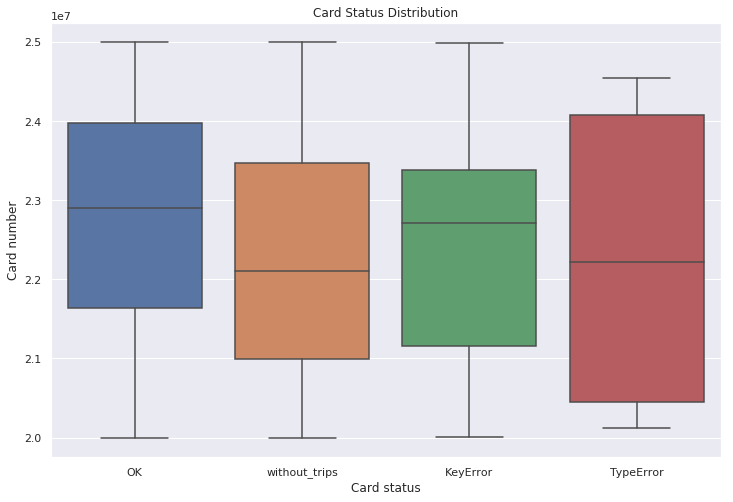

In [205]:
_ = plt.figure(figsize=(12, 8))
_ = sns.boxplot(x='status', y='number', data=df)
_ = plt.ylabel('Card number')
_ = plt.xlabel('Card status')
_ = plt.title('Card Status Distribution')

### ¿Cómo se distribuyen los viajes en función del horario?

In [387]:
trips = []
for index, row in df[df['status'] == 'OK'].iterrows():
    trips += [trip for trip in row['data']['trips']]

In [388]:
trips = pd.DataFrame(trips)

In [389]:
trips.head()

,activity,amount,balance,date_time,place,transaction
0,Carga Tarjeta,2.000,1.570,17-07-2018 09:14,Gruta de Lourdes - L5,64
1,Uso Tarjeta,660,-430,13-07-2018 13:05,FLXC-20 T407,63
2,Uso Tarjeta,660,230,12-07-2018 20:42,RM-0938 ZONA PAGA,62
3,Uso Tarjeta,660,890,12-07-2018 12:27,ZN-5304 T407,61
4,Carga Tarjeta,1.000,1.550,12-07-2018 12:16,95335 - Farm Espoz - San Pablo 4102 - Quinta N...,60


In [390]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3137822 entries, 0 to 3137821
Data columns (total 6 columns):
activity       object
amount         object
balance        object
date_time      object
place          object
transaction    object
dtypes: object(6)
memory usage: 143.6+ MB


In [391]:
trips['activity'] = trips['activity'].astype('category')
trips['place'] = trips['place'].astype('category')

In [392]:
trips['amount'] = trips['amount'].str.replace('.', '')
trips['amount'] = pd.to_numeric(trips['amount'], errors='coerce', downcast='integer')

trips['balance'] = trips['balance'].str.replace('.', '')
trips['balance'] = pd.to_numeric(trips['balance'], errors='coerce', downcast='integer')

In [393]:
trips['date_time'] = trips['date_time'].str.replace('-', '/')
trips['date_time'] = pd.to_datetime(trips['date_time'], format="%d/%m/%Y %H:%M", errors='coerce')
trips = trips.drop(trips[trips['date_time'].isnull()].index)

In [394]:
trips['transaction'] = trips['transaction'].astype(int)

In [395]:
trips.index = trips['date_time']
del trips['date_time']

In [396]:
trips.head()

,activity,amount,balance,place,transaction
date_time,,,,,
2018-07-17 09:14:00,Carga Tarjeta,2000.0,1570.0,Gruta de Lourdes - L5,64
2018-07-13 13:05:00,Uso Tarjeta,660.0,-430.0,FLXC-20 T407,63
2018-07-12 20:42:00,Uso Tarjeta,660.0,230.0,RM-0938 ZONA PAGA,62
2018-07-12 12:27:00,Uso Tarjeta,660.0,890.0,ZN-5304 T407,61
2018-07-12 12:16:00,Carga Tarjeta,1000.0,1550.0,95335 - Farm Espoz - San Pablo 4102 - Quinta N...,60


In [397]:
day_count = trips.resample('D').count()['activity']

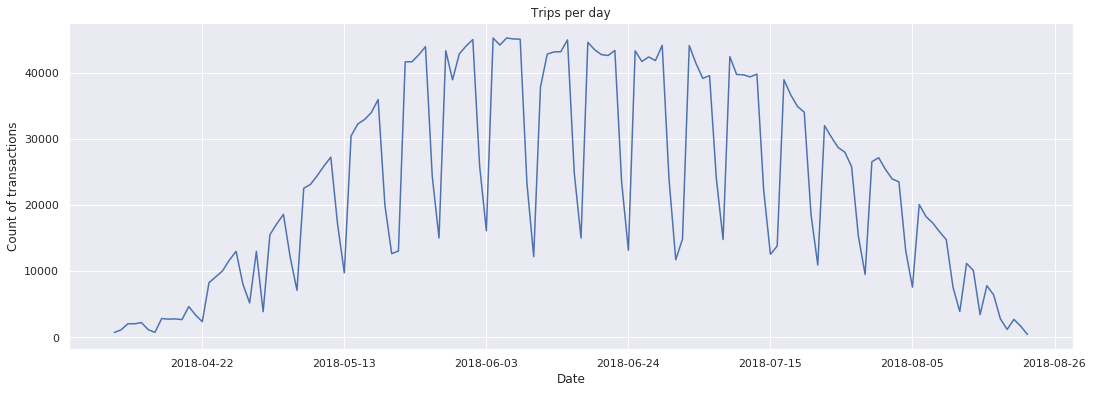

In [398]:
_ = plt.figure(figsize=(18, 6))
_ = plt.plot(day_count)
_ = plt.title("Trips per day")
_ = plt.xlabel('Date')
_ = plt.ylabel('Count of transactions')

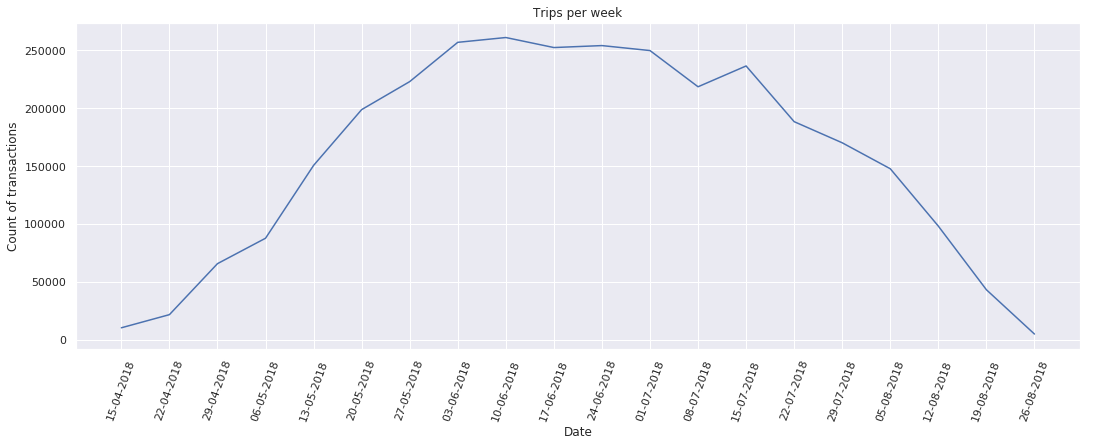

In [422]:
week_count = trips.resample('W').count()['activity']
_ = plt.figure(figsize=(18, 6))
_ = plt.plot(week_count)
_ = plt.title("Trips per week")
_ = plt.xlabel('Date')
_ = plt.ylabel('Count of transactions')
_ = plt.xticks(week_count.index, week_count.index.strftime("%d-%m-%Y"), rotation=70)

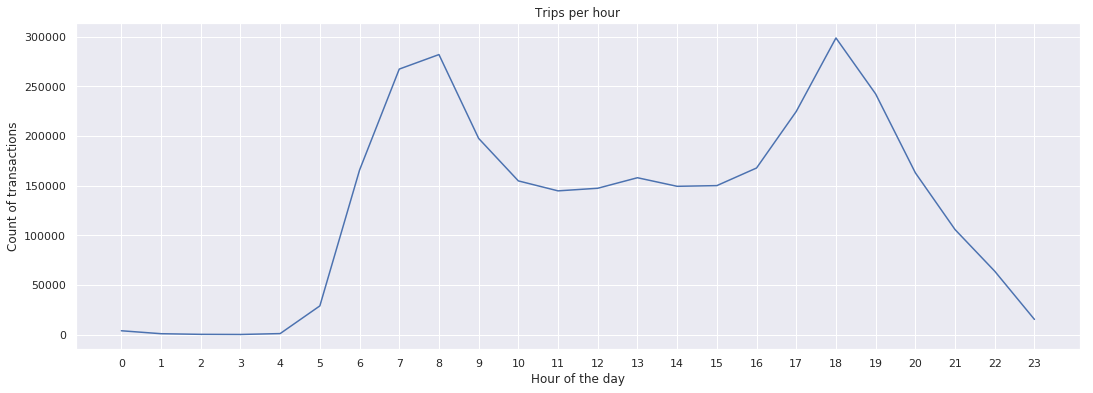

In [429]:
hour_count = trips.groupby(trips.index.hour).count()['activity']
_ = plt.figure(figsize=(18, 6))
_ = plt.plot(hour_count)
_ = plt.title("Trips per hour")
_ = plt.xlabel('Hour of the day')
_ = plt.ylabel('Count of transactions')
_ = plt.xticks(hour_count.index, hour_count.index)